In [1]:
import os
import pickle
import uuid
from typing import Final, Optional

import cv2 as OpenCV
import numpy as np
import trimesh
from numpy.linalg import norm
from scipy.cluster.vq import kmeans, vq
from scipy.spatial import Delaunay

In [2]:
class CalibrationError(Exception):
    def __init__(self, message):
        self.message = message

class IntrinsicParametersNotFoundError(Exception):
    def __init__(self, message):
        self.message = message

In [3]:
class Image:
    def __init__(self, img_id, rgb_image, gray_image, keypoints, descriptors, path):
        self.img_id: int = img_id
        self.unique_id: uuid = uuid.uuid4()
        self.rgb_image: Image = rgb_image
        self.gray_image: Image = gray_image
        self.keypoints: list[OpenCV.KeyPoint] = keypoints
        self.descriptors: np.ndarray = descriptors
        self.path: str = path
        self.similar_images: list[tuple[Image, float]] = []

    @property
    def length(self):
        return f"{len(self.keypoints)}" if len(self.keypoints) == len(self.descriptors) else f"{len(self.keypoints)}, {len(self.descriptors)}"
    
    def __repr__(self):
        return f"Image({self.img_id})"
    
    def __str__(self):
        return self.__repr__()
    
    def __eq__(self, other):
        return self.unique_id == other.unique_id
    
    def __hash__(self):
        return hash(self.img_id)
    
    def __getstate__(self):
        state = self.__dict__.copy()
        state['keypoints'] = [tuple(k.pt) + (k.size, k.angle, k.response, k.octave, k.class_id) for k in self.keypoints]
        return state
    
    def __setstate__(self, state):
        state['keypoints'] = [OpenCV.KeyPoint(x, y, size, angle, response, octave, class_id) for x, y, size, angle, response, octave, class_id in state['keypoints']]
        self.__dict__ = state

class FeatureMatches:
    def __init__(self, image_one: Image, image_two: Image, matches: list[OpenCV.DMatch]):
        self.image_one: Image = image_one
        self.image_two: Image = image_two
        self.matches: list[OpenCV.DMatch] = matches

    def __repr__(self):
        return f"FeatureMatches({self.image_one}, {self.image_two} ---> {len(self.matches)})"

    def __getstate__(self):
        state = self.__dict__.copy()
        state['matches'] = [
            {'queryIdx': m.queryIdx, 'trainIdx': m.trainIdx, 'distance': m.distance} for m in self.matches
        ]
        return state
    
    def __setstate__(self, state):
        state['matches'] = [
            OpenCV.DMatch(match['queryIdx'], match['trainIdx'], match['distance']) for match in state['matches']
        ]
        self.__dict__ = state
    
class Images:
    def __init__(self, images: list[Image], image_set_name: str):
        self.id = uuid.uuid4()
        self.images: list[Image] = images
        self.image_set_name: str = image_set_name
        self.feature_matches: list[FeatureMatches] = []

    def __len__(self):
        return len(self.images)

In [4]:
""" Step One: Read and Load Images
Inputs: 
- folder_path: str

Outputs:
- images: Images

Main Functions:
1. prepare_images: read and load images from a folder into an Images object

Utils Functions:
1. dump_images: dump images to a pickle file
2. load_images: load images from a pickle file
"""

def prepare_images(folder_path: str) -> Images:
    """ Read and load images """
    images: Images = Images([], folder_path.split("/")[-1])
    files: list[str] = filter(lambda file: ".jpg" in file, os.listdir(folder_path))
    for i, file in enumerate(files):
        image_path = f"{folder_path}/{file}"
        rgb_image = OpenCV.cvtColor(OpenCV.imread(image_path), OpenCV.COLOR_BGR2RGB)
        gray_image = OpenCV.cvtColor(rgb_image, OpenCV.COLOR_RGB2GRAY)
        images.images.append(Image(i, rgb_image, gray_image, [], [], image_path))
    return images

def dump_images_bak(images_file_path: str, images: Images) -> None:
    """ Dump images to a file """
    with open(images_file_path, "wb") as file:
        prepare_images.dump(images, file)

def load_images_bak(images_file_path: str) -> Images:
    """ Load images from a file """
    with open(images_file_path, "rb") as file:
        images = pickle.load(file)
    return images

In [5]:
"""Step Two: Feature Extraction
Inputs:
- images: Images
- SIFT: OpenCV.SIFT

Outputs:
- image: Image
--> image.keypoints: list[OpenCV.KeyPoint]
--> image.descriptors: np.ndarray

Main Functions:
1. compute_keypoints_descriptors
"""

def compute_keypoints_descriptors(images: list[Image], SIFT: OpenCV.SIFT) -> None:
    """Compute keypoints and descriptors for each image in the list of images using SIFT algorithm.
    Modifies each image in the list of images by adding its keypoints and descriptors as attributes.
    
    Args:
    - images: List of images to compute keypoints and descriptors for.
    - SIFT: OpenCV SIFT object used to detect and compute keypoints and descriptors.

    Returns:
    - None.
    """
    for img in images.images:
        keypoints: list[OpenCV.KeyPoint]
        descriptors: np.ndarray
        keypoints, descriptors = SIFT.detectAndCompute(img.gray_image, None)
        img.keypoints = keypoints
        img.descriptors = descriptors

In [6]:
""" Step Three: Image Matching
Inputs:
- descriptors: list[np.ndarray]

Outputs:
- centroids: np.ndarray
- variance: np.ndarray
- CLUSTER_COUNT: int
- matches_ids: list[list[tuple[int, float]]]

Main Functions:
1. get_matches

Utils Functions:
1. get_matches_ids

Sub Utils Functions:
1. get_visual_words
2. get_frequency_vectors
3. get_tf_idf
4. search_matches
"""

def get_matches(images: Images) -> None:
    """ Match images using k-means clustering.
    Args:
        images: Obj from Images class.
    """
    all_descriptors = np.concatenate([image.descriptors for image in images.images])
    CLUSTER_COUNT: Final = 400
    ITER: Final = 2
    centroids, _ = kmeans(all_descriptors, CLUSTER_COUNT, ITER)
    matches_ids: list[list[tuple[int, float]]] =  get_matches_ids([image.descriptors for image in images.images], centroids, images.images)
    for i, image in enumerate(images.images):
        inner_list: list[Image, float] = [
            (images.images[match[0]], match[1]) for match in matches_ids[i]
        ]
        image.similar_images = inner_list


def get_visual_words(descriptors: list[np.ndarray], centroids: np.ndarray) -> list[np.ndarray]:
    """ Get the visual words of a list of descriptors.
    Args:
        descriptors: A list of numpy arrays containing image descriptors.
        centroids: A numpy array containing cluster centroids.
    Returns:
        A list of numpy arrays representing the visual words of each image.
    """
    visual_words = []
    for descriptor in descriptors:
        words, _ = vq(descriptor, centroids)
        visual_words.append(words)
    return visual_words


def get_frequency_vectors(visual_words: list[np.ndarray], CLUSTER_COUNT: int) -> np.ndarray:
    """ Get the frequency vectors for a list of visual words.
    Args:
        visual_words: A list of numpy arrays representing the visual words of each image.
        CLUSTER_COUNT: The number of clusters used to generate the visual words.
    Returns:
        A numpy array containing the frequency vectors for each image.
    """
    frequency_vectors = []
    for img_words in visual_words:
        histogram = np.zeros(CLUSTER_COUNT)
        for word in img_words:
            histogram[word] += 1
        frequency_vectors.append(histogram)
    return np.stack(frequency_vectors)


def get_tf_idf(frequency_vectors, IMAGES_COUNT) -> np.ndarray:
    """ Get the Term Frequency-Inverse Document Frequency (TF-IDF) matrix for a list of frequency vectors.
    Args:
        frequency_vectors: A numpy array containing the frequency vectors for each image.
        IMAGES_COUNT: The total number of images in the dataset.
    Returns:
        A numpy array containing the TF-IDF matrix for the input frequency vectors.
    """
    df = np.sum(frequency_vectors > 0, axis = 0)
    idf = np.log(IMAGES_COUNT/df)
    return frequency_vectors * idf


def search_matches(i, top_clusters, tf_idf) -> list[tuple[int, float]]:
    """ Search for the top_clusters most similar images to the i-th image
    Args:
        i: the index of the image to search for similar images
        top_clusters: the number of similar images to return
        tf_idf: Term Frequency-Inverse Document Frequency
    Returns:
        A list of tuples, where each tuple contains the index of a similar image and the cosine similarity 
        between the i-th image and the similar image. The list is sorted by the cosine similarity in 
        descending order.
    """
    b = tf_idf
    a = tf_idf[i]
    b_subset = b[:tf_idf.shape[0]]
    cosine_similarity = np.dot(a, b_subset.T)/(norm(a) * norm(b_subset, axis=1))
    idx = np.argsort(-cosine_similarity)[:top_clusters]
    return list(zip(idx, cosine_similarity[idx]))


def get_matches_ids(descriptors, centroids, images_list) -> list[list[tuple[int, float]]]:
    """Returns: a list of lists, where each list contains the top 10 most similar images to the i-th image."""
    visual_words = get_visual_words(descriptors, centroids)
    frequency_vectors = get_frequency_vectors(visual_words, centroids.shape[0])
    """ tf_idf: Term Frequency-Inverse Document Frequency """
    tf_idf = get_tf_idf(frequency_vectors, len(images_list))
    return [
        search_matches(i, 10, tf_idf)
        for i in range(len(images_list))
    ]

In [7]:
"""Step Four: Feature Matching
Inputs:
- images: Images

Outputs:
- None

Main Functions:
1. data_feature_matching

Utils Functions:
1. feature_matching
"""

def feature_matching(
        img_one_descriptors: np.ndarray, 
        img_two_descriptors: np.ndarray
    ) -> list[OpenCV.DMatch]:
    """ Match features between two images using Brute Force Matcher
    Args:
        img_id_one: the index of the first image
        img_id_two: the index of the second image
        descriptors: a list of descriptors of the images
    Returns:
        A list of OpenCV.DMatch objects.
    """
    matcher = OpenCV.BFMatcher()
    return matcher.match(img_one_descriptors, img_two_descriptors)

def data_feature_matching(images: Images) -> None:
    """ Match features between images using Brute Force Matcher
    Args:
        matchesIDs: a list of lists of tuples, where each tuple contains the index of a similar image and the cosine similarity 
            between the i-th image and the similar image. The list is sorted by the cosine similarity in 
            descending order.
        descriptors: a list of descriptors of the images
    Returns:
        A list of lists, where each list contains 
        the index of the first image, the index of the second image, 
        and a list of OpenCV.DMatch objects.
    """
    num_images: int = len(images.images)
    checked = np.zeros((num_images, num_images), dtype=int)
    for image in images.images:
        for matched_image, probability in image.similar_images:
            if ((checked[image.img_id][matched_image.img_id] == 0 or checked[matched_image.img_id][image.img_id] == 0) and image.img_id != matched_image.img_id and probability > 0.93):
                images.feature_matches.append(FeatureMatches(image, matched_image, feature_matching(image.descriptors, matched_image.descriptors)))
                checked[image.img_id][matched_image.img_id], checked[matched_image.img_id][image.img_id] = 1, 1

In [8]:
"""Step Five: Camera Calibration
Inputs:
- None.

Outputs:
- k_matrix: np.ndarray

ToDo:
1- generate K_matrix.pickle for each camera using Chess board pattern.
"""

'Step Five: Camera Calibration\nInputs:\n- None.\n\nOutputs:\n- k_matrix: np.ndarray\n\nToDo:\n1- generate K_matrix.pickle for each camera using Chess board pattern.\n'

In [9]:
"""Step Six: Triangulation (3D Reconstruction)
Inputs:
- feature_matches_list: list[list[int, int, list[OpenCV.DMatch]]]
    -> A list of lists, where each list contains 
        the index of the first image, the index of the second image, 
        and a list of OpenCV.DMatch objects.
- K_matrix: np.ndarray
    -> The camera matrix of the camera used to take the images.

Outputs:
- point_cloud: list[np.ndarray]; each element is a 3D point.

Main Functions:
1. generate_point_cloud

Utils Functions:
1. triangulatePoints
"""

def triangulatePoints(P1, P2, pts1, pts2):
    """
    Triangulates the given matching points from two images using the given camera matrices.

    Parameters:
    P1 (numpy.ndarray): 3x4 camera matrix of the first image.
    P2 (numpy.ndarray): 3x4 camera matrix of the second image.
    pts1 (numpy.ndarray): Nx2 matrix containing the coordinates of matching points in the first image.
    pts2 (numpy.ndarray): Nx2 matrix containing the coordinates of matching points in the second image.

    Returns:
    numpy.ndarray: Nx3 matrix containing the triangulated 3D points.
    """
    pts4D = OpenCV.triangulatePoints(P1, P2, pts1.T, pts2.T)
    pts4D /= pts4D[3]
    return pts4D[:3].T


def generate_point_cloud(images: Images, K_matrix):
    """
    Generates a cloud of 3D points using triangulation from feature matches and camera calibration matrix.

    Parameters:
    feature_matches_list (list): List of feature matches between images.
    K_matrix (numpy.ndarray): 3x3 camera calibration matrix.

    Returns:
    numpy.ndarray: Nx3 matrix containing the cloud of 3D points.
    """
    point_cloud = []
    feature_matches_list = images.feature_matches
    for match in feature_matches_list:
        img_one = match.image_one
        img_two = match.image_two
        matches = match.matches
        pts1 = np.float32([img_one.keypoints[m.queryIdx].pt for m in matches])
        pts2 = np.float32([img_two.keypoints[m.trainIdx].pt for m in matches])
        E, _ = OpenCV.findEssentialMat(pts1, pts2, K_matrix)
        R1, R2, t = OpenCV.decomposeEssentialMat(E)
        P1 = np.hstack((np.eye(3), np.zeros((3,1))))
        P2 = np.hstack((R1, t))
        pts_3d = triangulatePoints(P1, P2, pts1, pts2)
        point_cloud.append(pts_3d)
    return np.concatenate(point_cloud, axis=0)


In [10]:
print("Welcome ScanMate...")
image_set_name = "snow-man"
images: Optional[Images] = None
# Reload the last state
last_state: str
if os.path.isfile(f"bak/{image_set_name}/point-cloud.pkl"):
    last_state = "Point Cloud Step"
elif os.path.isfile(f"bak/{image_set_name}/feature-matching-output.pkl"):
    last_state = "Feature Matching Step"
elif os.path.isfile(f"bak/{image_set_name}/images-matched.pkl"):
    last_state = "Images Matching Step"
elif os.path.isfile(f"bak/{image_set_name}/sift-features.pkl"):
    last_state = "SIFT Features Step"
else:
    last_state = "Images Loading Step"

Welcome ScanMate...


In [11]:
# 1. Load and prepare Images
if last_state == "Images Loading Step":
    if os.path.isfile(f"bak/{image_set_name}/images.pkl"):
        print(f"File [bak/{image_set_name}/sift-images.pkl] exists")
        print("Loading images from pickle file...")
        images: Images = load_images_bak(f"bak/{image_set_name}/images.pkl")
    else:
        print(f"File [bak/{image_set_name}/images.pkl] does not exist")
        print("Loading images from images directory...")
        images: Images = prepare_images(f"images/{image_set_name}")
        print("Saving images to pickle file...")
        dump_images_bak(f"bak/{image_set_name}/images.pkl", images)
    print("Images loaded successfully")
    last_state = "SIFT Features Step"

In [12]:
# 2. Feature Extraction: SIFT
if last_state == "SIFT Features Step":
    if os.path.isfile(f"bak/{image_set_name}/sift-features.pkl"):
        print(f"File [bak/{image_set_name}/sift-features.pkl] exists")
        if images: 
            del images
        images: Images = load_images_bak(f"bak/{image_set_name}/sift-features.pkl")
    else:
        print("File [bak/{image_set_name}/sift-features.pkl] DO NOT exists")
        print("Extracting SIFT features...")
        sift = OpenCV.SIFT_create()
        compute_keypoints_descriptors(images, sift)
        dump_images_bak(f"bak/{image_set_name}/sift-features.pkl", images)
    print("Feature Extraction: SIFT DONE...")
    last_state = "Images Matching Step"

In [13]:
# 3. Image Matching
if last_state == "Images Matching Step":
    if os.path.isfile(f"bak/{image_set_name}/images-matched.pkl"):
        print(f"File [bak/{image_set_name}/images-matched.pkl] exists")
        if images: 
            del images
        images: Images = load_images_bak(f"bak/{image_set_name}/images-matched.pkl")
    else:
        print(f"File [bak/{image_set_name}/images-matched.pkl] DO NOT exists")
        get_matches(images)
        dump_images_bak(f"bak/{image_set_name}/images-matched.pkl", images)
    print("Done Image Matching Step...")
    last_state = "Feature Matching Step"

In [14]:
# 4. Feature Matching
if last_state == "Feature Matching Step":
    if os.path.isfile(f"bak/{image_set_name}/feature-matching-output.pkl"):
        print(f"File [bak/{image_set_name}/feature-matching-output.pkl] exists")
        if images: 
            del images
        images: Images = load_images_bak(f"bak/{image_set_name}/feature-matching-output.pkl")
    else:
        print("File [bak/{image_set_name}/feature-matching-output.pkl] Do NOT exists")
        # logging.info('----> Processing {image_set_name}...')
        data_feature_matching(images)
        dump_images_bak(f"bak/{image_set_name}/feature-matching-output.pkl", images)
    print("Done Feature Matching Step...")
    last_state = "Point Cloud Step"

In [15]:
# 5. Camera Calibration
print("Camera Calibration starts ....")
if not os.path.isfile("bak/snow-man/checker/K_matrix.pickle"):
    raise IntrinsicParametersNotFoundError("Intrinsic parameters not found")
print("File bak/snow-man/checker/K_matrix.pickle exists")
with open('bak/snow-man/checker/K_matrix.pickle', 'rb') as f:
    K_matrix = pickle.load(f)

Camera Calibration starts ....
File bak/snow-man/checker/K_matrix.pickle exists


In [16]:
# 6. Triangulation (3D reconstruction)
print("Triangulation starts ....")
if last_state == "Point Cloud Step":
    if os.path.isfile(f"bak/{image_set_name}/point-cloud.pkl"):
        with open(f"bak/{image_set_name}/point-cloud.pkl", 'rb') as f:
            points_cloud: np.ndarray = pickle.load(f)
    else:
        points_cloud: np.ndarray = generate_point_cloud(images, K_matrix)
        # Pickle the point cloud
        with open(f"bak/{image_set_name}/point-cloud.pkl", 'wb') as f:
            pickle.dump(points_cloud, f)

Triangulation starts ....


In [17]:
print(f"points_cloud.shape: {points_cloud.shape}")
# Save the point cloud to a file
# np.savetxt(f"output/{image_set_name}/point-cloud.txt", points_cloud)

points_cloud.shape: (17264381, 3)


In [18]:
# Define the scale factors for each axis
x_scale = 1 / 4_607_147_648.0
y_scale = 1 / 15_070_119_136.0
z_scale = 1 / 7_987_284.25

# Apply the scale factors to each axis
scaled_x = points_cloud[:, 0] * x_scale
scaled_y = points_cloud[:, 1] * y_scale
scaled_z = points_cloud[:, 2] * z_scale

# Combine the scaled coordinates into a single NumPy array
scaled_point_cloud = np.column_stack((scaled_x, scaled_y, scaled_z))

In [19]:
print(f"X: {scaled_point_cloud[:,0].min()} to {scaled_point_cloud[:,0].max()}")
print(f"Y: {scaled_point_cloud[:,1].min()} to {scaled_point_cloud[:,1].max()}")
print(f"Z: {scaled_point_cloud[:,2].min()} to {scaled_point_cloud[:,2].max()}")

# X: -11_104_403_456.0 to 13_609_891_840.0
# Y: -8_873_204_736.0 to 21_268_033_536.0
# Z: -4_396_466.5 to 10_580_818.0

X: -0.002410255605354905 to 0.0029540820978581905
Y: -0.000588794588111341 to 0.0014112717472016811
Z: -0.0005504331784322858 to 0.0013247078750282526


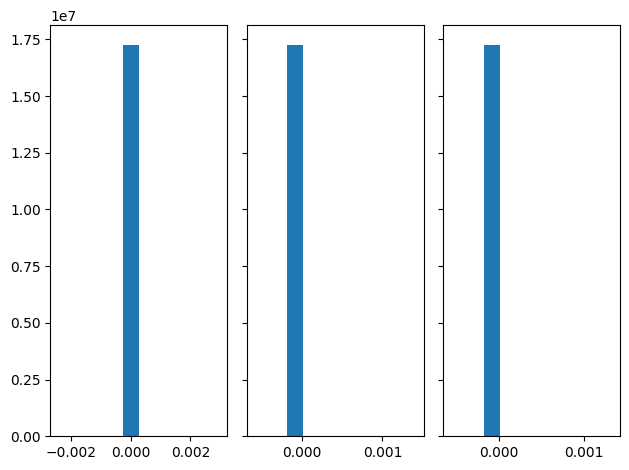

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(scaled_point_cloud[:, 0], bins=10)
axs[1].hist(scaled_point_cloud[:, 1], bins=10)
axs[2].hist(scaled_point_cloud[:, 2], bins=10)
plt.show()

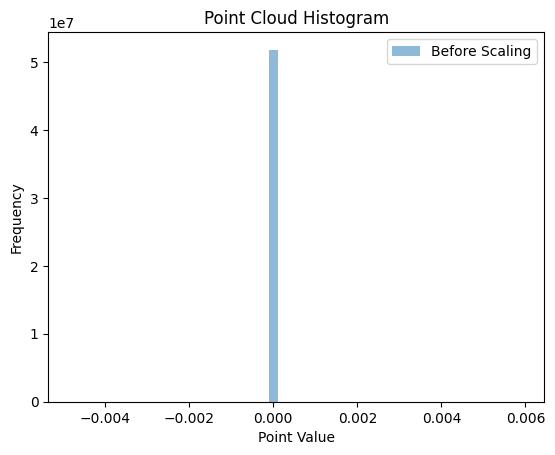

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Generate point cloud
# point_cloud = np.random.rand(10000, 3)

# Define scaling factor
scale_factor = 2.0

# Scale the point cloud
scaled_point_cloud = scaled_point_cloud * scale_factor

# Plot histogram of scaled_point_cloud
plt.hist(scaled_point_cloud.flatten(), bins=50, alpha=0.5, label='Before Scaling')
# Plot histogram of scaled_point_cloud
# plt.hist(scaled_point_cloud.flatten(), bins=50, alpha=0.5, label='After Scaling')

# Add titles and labels to the plot
plt.title('Point Cloud Histogram')
plt.xlabel('Point Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [22]:
points_cloud *= 1000

In [23]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_cloud[:,:3])

In [24]:
# o3d.visualization.draw_geometries([pcd])

In [25]:
# Save it as a.STL file
o3d.io.write_point_cloud("point_cloud.ply", pcd)

True